In [1]:
from pydrake.all import (
    MathematicalProgram,
    SnoptSolver,
)
import numpy as np
import matplotlib.pyplot as plt
from trajectory_generator import TrajectoryGenerator

In [2]:
# numeric parameters
k = 4
keyframes = np.array([0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105.0])
m = keyframes.shape[0] - 1 # number of keyframes
ts = 1.0 # unscaled time between keyframes

# initialize optimization
prog = MathematicalProgram()

# optimization variables
c = prog.NewContinuousVariables(k, m, "sigma")

# Zero initial and final velocity
prog.AddConstraint(c[0,0] == 0.0)
prog.AddConstraint(np.sum([(1/np.math.factorial(i))*ts**i*c[i,m-1] for i in range(k)]) == 0.0)

# Dynamics/Keyframe constraints
for j in range(m):
    eval_derivs = np.sum([(1/np.math.factorial(i))*ts**i*c[i-1,j] for i in range(1,k+1)])
    prog.AddConstraint(float(keyframes[j+1]) == float(keyframes[j]) + eval_derivs)

for j in range(m-1):
    for i in range(k-1):
        prog.AddConstraint(c[i, j+1] == np.sum([(1/np.math.factorial(i2))*ts**i2*c[i+i2, j] for i2 in range(k-i)]))


prog.AddCost(c[k-1,:] @ np.eye(m) @ c[k-1,:])



In [3]:
# solve mathematical program
solver = SnoptSolver()
result = solver.Solve(prog)

# be sure that the solution is optimal
assert result.is_success()

# retrieve optimal solution
c_opt = result.GetSolution(c)
print(c_opt)
print(c_opt[k-1,:] @ np.eye(m) @ c_opt[k-1,:])
# print(sigma_opt.reshape((-1,1)))
# print(sigma_opt.reshape((-1,1)).T @ H @ sigma_opt.reshape((-1,1)))

[[ 0.00000000e+00  1.65152919e+01  1.48470806e+01  1.50139018e+01
   1.50139018e+01  1.48470806e+01  1.65152919e+01]
 [ 7.34847081e+01 -7.42354032e+00  7.50695088e-01 -8.34105653e-02
   8.34105653e-02 -7.50695088e-01  7.42354032e+00]
 [-1.80000000e+02  1.81835032e+01 -1.83503244e+00  1.66821131e-01
   1.66821131e-01 -1.83503244e+00  1.81835032e+01]
 [ 1.98183503e+02 -2.00185357e+01  2.00185357e+00  0.00000000e+00
  -2.00185357e+00  2.00185357e+01 -1.98183503e+02]]
79362.90029298041


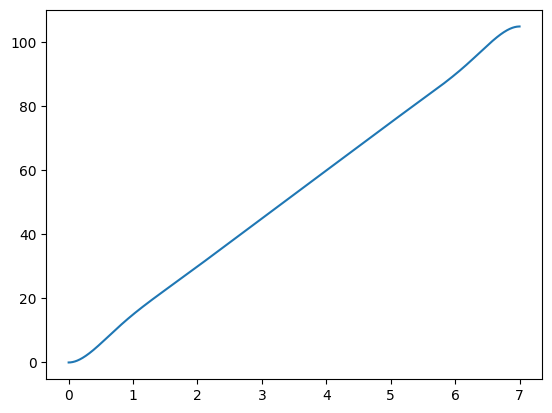

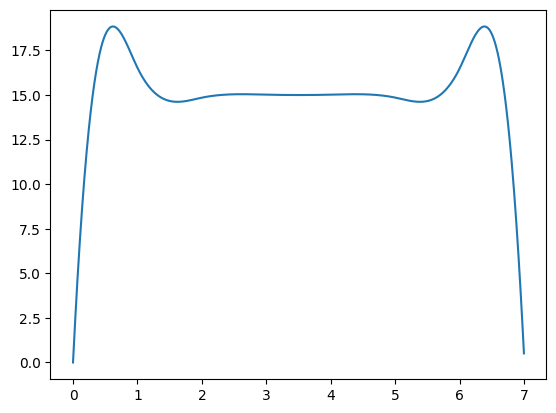

In [4]:
t = np.linspace(0, ts*m, 1000)

def x(c, t):
    interval = int(t / ts)
    curr_ts = t % ts
    if np.allclose(curr_ts, 0.0):
        return keyframes[interval]
    return keyframes[interval] + np.sum([(1/np.math.factorial(j))*curr_ts**j*c[j-1, interval] for j in range(1,k+1)]) 

def der(c, t, n):
    interval = int(t / ts)
    curr_ts = t % ts
    return np.sum([(1/np.math.factorial(j))*curr_ts**j*c[j+n-1, interval] for j in range(k-(n-1))])

x_vals = [x(c_opt, t[idx]) for idx in range(t.shape[0])]
plt.plot(t, x_vals)
plt.show()
xdot_vals = [der(c_opt, t[idx], 1) for idx in range(t.shape[0] - 1)]
plt.plot(t[:-1], xdot_vals)

0
1
2
3


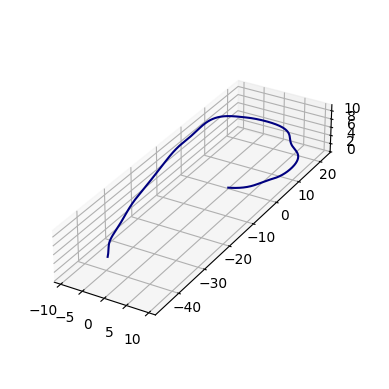

In [5]:
waypoints = np.array([
    [0.0, 0.0, 0.0],
    [5.0, 2.0, 1.0],
    [8.0, 5.0, 2.0],
    [10.0, 10.0, 3.0],
    [8.0, 15.0, 4.0],
    [5.0, 18.0, 5.0],
    [0.0, 20.0, 6.0],
    [-5.0, 18.0, 7.0],
    [-8.0, 15.0, 8.0],
    [-10.0, 9.0, 9.0],
    [-9.0, 2.0, 10.0],
    [-8.0, -5.0, 11.0],
    [-7.0, -14.0, 11.0],
    [-6.0, -24.0, 10.0],
    [-5.0, -32.0, 9.0],
    [-4.0, -38.0, 8.0],
    [-3.0, -42.0, 7.0],
    [-2.0, -44.0, 6.0],
]).T

headings = np.linspace(0.0, 2*np.pi, 2*waypoints.shape[1]-3).tolist()
for i in range(waypoints.shape[1]-3):
    del headings[-3 - i]
headings = np.array(headings)

traj_gen = TrajectoryGenerator(waypoints, headings)
traj_gen.solve()

t = np.linspace(0, traj_gen.ts*traj_gen.m, 1000)


x_vals = [traj_gen.eval_trajectory(t[idx], 0)[0] for idx in range(t.shape[0])]
# plt.plot(t, x_vals)
# plt.show()

# x_vals = [traj_gen.eval_trajectory(t[idx], 2)[0] for idx in range(t.shape[0])]
# plt.plot(t, x_vals)

# x_vals = [traj_gen.eval_trajectory(t[idx], 3)[0] for idx in range(t.shape[0])]
# plt.plot(t, x_vals)
# plt.show()

ax = plt.axes(projection='3d')

# Data for a three-dimensional line
x = [traj_gen.eval_trajectory(t[idx], 0)[0] for idx in range(t.shape[0])]
y = [traj_gen.eval_trajectory(t[idx], 0)[1] for idx in range(t.shape[0])]
z = [traj_gen.eval_trajectory(t[idx], 0)[2] for idx in range(t.shape[0])]
ax.plot3D(x, y, z, 'navy')
ax.set_aspect('equal')
plt.show()